# Tutorial: GEPA for Structured Information Extraction for Enterprise Tasks

See the original DSPy version [here](https://dspy.ai/tutorials/gepa_facilitysupportanalyzer/)

This notebook reproduces the DSPy version using our custom adapter. This allows us to use pydantic-ai's structured output support directly with the canonical GEPA api. 

The DSPy version relies on three separate model calls to produce the output attributes of `urgency`, `sentiment`, and list of `categories`. Here, we leverage a single output schema and thus one api call prediction.

In [1]:
import json
import os
import sys
from typing import Literal

from pydantic import BaseModel, Field

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
from src.gepadantic.scaffold import GepaConfig, run_optimization_pipeline

In this tutorial, we'll explore a three-part task for structured information extraction and classification using the [Facility Support Analyzer](https://github.com/meta-llama/prompt-ops/tree/main/use-cases/facility-support-analyzer) dataset released by Meta. Given an email or message sent in an enterprise setting related to facility maintenance or support requests, the goal is to extract its urgency, assess the sentiment, and identify all relevant service request categories.

In [4]:
import requests


url = "https://raw.githubusercontent.com/meta-llama/llama-prompt-ops/refs/heads/main/use-cases/facility-support-analyzer/dataset.json"
dataset = json.loads(requests.get(url).text)

In [5]:
dataset[0]

{'fields': {'input': 'Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given the high standard

In [6]:
dataset[0]['fields']['input']


'Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given the high standards we have come to exp

In [7]:
dataset[0]['answer']

'{"categories": {"routine_maintenance_requests": false, "customer_feedback_and_complaints": false, "training_and_support_requests": false, "quality_and_safety_concerns": false, "sustainability_and_environmental_practices": false, "cleaning_services_scheduling": false, "specialized_cleaning_services": true, "emergency_repair_services": false, "facility_management_issues": false, "general_inquiries": false}, "sentiment": "neutral", "urgency": "high"}'

## Define input model

In [8]:
class EmailInput(BaseModel):
    """Input model for email classification."""
    
    input: str = Field(description="The email content to classify")


In [9]:
from typing import Any

from gepadantic.types import InputModelT, DataInstWithInput


def init_dataset(
    input_data: list[dict[str, Any]],
) -> list[DataInstWithInput[InputModelT]]:
    """Load data from a list of dicts and convert to DataInstWithInput instances."""
    
    dataset: list[DataInstWithInput[InputModelT]] = []

    for idx, item in enumerate(input_data):
        if not isinstance(item, dict):
            raise ValueError(f"Item at index {idx} is not a dict: {type(item)}")

        # Convert dict to input model using user-provided mapper
        try:
            input_instance = EmailInput(input=item['fields']['input'])
        except Exception as e:
            raise ValueError(f"Error mapping item {idx} to input model: {e}") from e

        # Extract metadata
        metadata = {
            'expected_output': json.loads(item['answer']),
        }

        case_id = f"item-{idx}"

        # Create DataInstWithInput
        data_inst = DataInstWithInput[InputModelT](
            input=input_instance,
            message_history=None,
            metadata=metadata,
            case_id=case_id,
        )
        dataset.append(data_inst)

    return dataset

In [10]:
prepared_dataset = init_dataset(dataset)

In [11]:
prepared_dataset[0].__dict__

{'input': EmailInput(input='Subject: Urgent Assistance Required for Specialized Cleaning Services\n\nDear ProCare Facility Solutions Support Team,\n\nI hope this message finds you well. My name is [Sender], and my family and I have been availing your services for our home for the past year. We have always appreciated the high standards and professionalism your team brings to maintaining our living environment.\n\nHowever, we are currently facing an urgent issue that requires immediate attention. We recently hosted a large gathering at our home, and despite our best efforts, there are several areas that now require specialized cleaning. Specifically, we need deep cleaning for our carpets and upholstery, as well as thorough window washing. The situation is quite pressing as we have more guests arriving soon, and we want to ensure our home is in pristine condition to welcome them.\n\nWe have tried some basic cleaning ourselves, but the results have not been satisfactory. Given the high st

In [12]:
import random

random.Random(42).shuffle(prepared_dataset)

train_set = prepared_dataset[:int(len(prepared_dataset) * 0.33)]
val_set = prepared_dataset[int(len(prepared_dataset) * 0.33):int(len(prepared_dataset) * 0.66)]
test_set = prepared_dataset[int(len(prepared_dataset) * 0.66):]

In [13]:
len(train_set), len(val_set), len(test_set)

(66, 66, 68)

In [14]:
print(train_set[0].input.input)

Subject: Inquiry About Your Eco-Friendly Practices

Dear ProCare Facility Solutions Support Team,

I hope this message finds you well. My name is [Sender], and I am a mother of a 10-year-old daughter who has recently started Irish dance. We live in a residential complex where your team provides cleaning and maintenance services.

I am writing to inquire about the eco-friendly practices your company employs. As someone who is conscious about the environment and wants to set a good example for my daughter, I am keen to understand how your services align with sustainable practices. Specifically, I am interested in the types of cleaning products you use and any measures you take to reduce the carbon footprint of your operations.

I have noticed that the cleaning staff is very diligent and thorough, which I appreciate. However, I would like to know more about the environmental impact of the products and methods used. Are there any certifications or standards that your company adheres to in 

## Define output model

In [15]:
class FacilitySupportAnalyzer(BaseModel):
    """Analyzes facility support requests."""
    
    urgency: Literal['low', 'medium', 'high'] = Field(description="The urgency of the request")
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="The sentiment of the request")
    categories: list[Literal[
        "emergency_repair_services", 
        "routine_maintenance_requests", 
        "quality_and_safety_concerns", 
        "specialized_cleaning_services", 
        "general_inquiries", 
        "sustainability_and_environmental_practices", 
        "training_and_support_requests", 
        "cleaning_services_scheduling", 
        "customer_feedback_and_complaints", 
        "facility_management_issues"]] = Field(description="The categories of the request")

In [16]:
from gepadantic.lm import get_openai_model
from pydantic_ai import Agent


DEFAULT_INSTRUCTIONS = """
Read the following facility support request and analyze it to determine the urgency, sentiment, and categories.
"""

DEFAULT_MODEL = "gpt-4.1-nano"


test_agent = Agent[None, FacilitySupportAnalyzer](
    model=get_openai_model(DEFAULT_MODEL),
    instructions=DEFAULT_INSTRUCTIONS,
    output_type=FacilitySupportAnalyzer,
    retries=5,
)

In [17]:
import nest_asyncio
nest_asyncio.apply()

test_response = test_agent.run_sync(train_set[0].input.input)

In [18]:
test_response.output.model_dump()

{'urgency': 'medium',
 'sentiment': 'positive',
 'categories': ['sustainability_and_environmental_practices']}

In [19]:
train_set[0].metadata['expected_output']

{'categories': {'routine_maintenance_requests': False,
  'customer_feedback_and_complaints': False,
  'training_and_support_requests': False,
  'quality_and_safety_concerns': False,
  'sustainability_and_environmental_practices': True,
  'cleaning_services_scheduling': False,
  'specialized_cleaning_services': True,
  'emergency_repair_services': False,
  'facility_management_issues': False,
  'general_inquiries': True},
 'sentiment': 'neutral',
 'urgency': 'low'}

* Simple baseline metric

In [20]:
def score_urgency(gold_urgency, pred_urgency):
    """
    Compute score for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    return score

def score_sentiment(gold_sentiment, pred_sentiment):
    """
    Compute score for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    return score

def score_categories(gold_categories, pred_categories):
    """
    Compute score for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correct = 0
    for k, v in gold_categories.items():
        if v and k in pred_categories:
            correct += 1
        elif not v and k not in pred_categories:
            correct += 1
    score = correct / len(gold_categories)
    return score

In [21]:
from gepadantic.types import DataInstWithInput, RolloutOutput


def metric(
    data_inst: DataInstWithInput[EmailInput],
    output: RolloutOutput[FacilitySupportAnalyzer],
) -> float:
    """Evaluate facility support request analysis.
    
    This metric checks if the predicted urgency, sentiment, and categories match the ground truth.
    
    Args:
        data_inst: Input data instance with metadata containing ground truth.
        output: Agent's output to evaluate.
        
    Returns:
        Float score between 0.0 and 1.0.
    """
    if not output.success:
        return 0.0
    
    # Extract predicted urgency, sentiment, and categories
    pred_urgency = output.result.urgency
    pred_sentiment = output.result.sentiment
    pred_categories = output.result.categories
    
    # Extract ground truth from metadata
    gold_urgency = data_inst.metadata['expected_output']['urgency']
    gold_sentiment = data_inst.metadata['expected_output']['sentiment']
    gold_categories = data_inst.metadata['expected_output']['categories']
    
    # Score each module
    urgency_score = score_urgency(gold_urgency, pred_urgency)
    sentiment_score = score_sentiment(gold_sentiment, pred_sentiment)
    categories_score = score_categories(gold_categories, pred_categories)
    
    # Calculate final score as average of all module scores
    final_score = (urgency_score + sentiment_score + categories_score) / 3.0
    
    return final_score

In [22]:
test_output = RolloutOutput(
    result=test_response.output,
    success=True,
)

metric(train_set[0], test_output)

0.26666666666666666

## Evaluate baseline model again holdout set

In [23]:
import numpy as np
import asyncio
import nest_asyncio

nest_asyncio.apply()


async def evaluate_single_instance(data_inst):
    """Evaluate a single test instance."""
    response = await test_agent.run(data_inst.input.input)
    output = RolloutOutput(
        result=response.output,
        success=True,
    )
    score = metric(data_inst, output)
    return score

async def evaluate_test_set_parallel():
    """Evaluate the test set with parallel execution."""
    # Create all tasks
    tasks = [
        evaluate_single_instance(test_set[i]) 
        for i in range(len(test_set))
    ]
    
    # Run all tasks concurrently
    scores = await asyncio.gather(*tasks)
    return scores


baseline_test_scores = await evaluate_test_set_parallel()

In [24]:
print(f"Baseline test score: {np.mean(baseline_test_scores)}")

Baseline test score: 0.7970588235294118


## GEPA Metric

Adds feedback string

In [25]:
def feedback_urgency(gold_urgency, pred_urgency):
    """
    Generate feedback for the urgency module.
    """
    score = 1.0 if gold_urgency == pred_urgency else 0.0
    if gold_urgency == pred_urgency:
        feedback = f"You correctly classified the urgency of the message as `{gold_urgency}`. This message is indeed of `{gold_urgency}` urgency."
    else:
        feedback = f"You incorrectly classified the urgency of the message as `{pred_urgency}`. The correct urgency is `{gold_urgency}`. Think about how you could have reasoned to get the correct urgency label."
    return feedback, score

def feedback_sentiment(gold_sentiment, pred_sentiment):
    """
    Generate feedback for the sentiment module.
    """
    score = 1.0 if gold_sentiment == pred_sentiment else 0.0
    if gold_sentiment == pred_sentiment:
        feedback = f"You correctly classified the sentiment of the message as `{gold_sentiment}`. This message is indeed `{gold_sentiment}`."
    else:
        feedback = f"You incorrectly classified the sentiment of the message as `{pred_sentiment}`. The correct sentiment is `{gold_sentiment}`. Think about how you could have reasoned to get the correct sentiment label."
    return feedback, score


def feedback_categories(gold_categories, pred_categories):
    """
    Generate feedback for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correctly_included = [k for k, v in gold_categories.items() if v and k in pred_categories]
    incorrectly_included = [k for k, v in gold_categories.items() if not v and k in pred_categories]
    incorrectly_excluded = [k for k, v in gold_categories.items() if v and k not in pred_categories]
    correctly_excluded = [k for k, v in gold_categories.items() if not v and k not in pred_categories]  # For completeness in accuracy check

    # Recompute category accuracy (matches score logic)
    score = (len(correctly_included) + len(correctly_excluded)) / len(gold_categories)

    if score == 1.0:
        fb_text = f"The category classification is perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`."
    else:
        fb_text = f"The category classification is not perfect. You correctly identified that the message falls under the following categories: `{repr(correctly_included)}`.\n"
        if incorrectly_included:
            fb_text += f"However, you incorrectly identified that the message falls under the following categories: `{repr(incorrectly_included)}`. The message DOES NOT fall under these categories.\n"
        if incorrectly_excluded:
            prefix = "Additionally, " if incorrectly_included else "However, "
            fb_text += f"{prefix}you didn't identify the following categories that the message actually falls under: `{repr(incorrectly_excluded)}`.\n"
        fb_text += "Think about how you could have reasoned to get the correct category labels."
    return fb_text, score

In [26]:
def metric_with_feedback(
    data_inst: DataInstWithInput[EmailInput],
    output: RolloutOutput[FacilitySupportAnalyzer],
) -> tuple[float, str | None]:
    """Evaluate facility support request analysis with feedback.
    
    This metric checks if the predicted urgency, sentiment, and categories match the ground truth.
    It also provides feedback on the reasoning process for each module.
    
    Args:
        data_inst: Input data instance with metadata containing ground truth.
        output: Agent's output to evaluate.
        
    Returns:
        Tuple of (score, feedback) where score is between 0.0 and 1.0.
    """
    
    # Extract predicted urgency, sentiment, and categories
    pred_urgency = output.result.urgency
    pred_sentiment = output.result.sentiment
    pred_categories = output.result.categories
    
    # Extract ground truth from metadata
    gold_urgency = data_inst.metadata['expected_output']['urgency']
    gold_sentiment = data_inst.metadata['expected_output']['sentiment']
    gold_categories = data_inst.metadata['expected_output']['categories']
    
    fb_urgency, score_urgency = feedback_urgency(gold_urgency, pred_urgency)
    fb_sentiment, score_sentiment = feedback_sentiment(gold_sentiment, pred_sentiment)
    fb_categories, score_categories = feedback_categories(gold_categories, pred_categories)
    
    # Calculate final score as average of all module scores
    final_score = (score_urgency + score_sentiment + score_categories) / 3.0
    
    # Combine feedback into a single string
    feedback = f"Urgency: {fb_urgency}\nSentiment: {fb_sentiment}\nCategories: {fb_categories}"
    
    return final_score, feedback

In [27]:
metric_with_feedback(train_set[0], test_output)

(0.26666666666666666,
 "Urgency: You incorrectly classified the urgency of the message as `medium`. The correct urgency is `low`. Think about how you could have reasoned to get the correct urgency label.\nSentiment: You incorrectly classified the sentiment of the message as `positive`. The correct sentiment is `neutral`. Think about how you could have reasoned to get the correct sentiment label.\nCategories: The category classification is not perfect. You correctly identified that the message falls under the following categories: `['sustainability_and_environmental_practices']`.\nHowever, you didn't identify the following categories that the message actually falls under: `['specialized_cleaning_services', 'general_inquiries']`.\nThink about how you could have reasoned to get the correct category labels.")

In [28]:
reflection_model = "gpt-5"
agent_model="gpt-4.1-nano"


config = GepaConfig(
    # Agent configuration
    agent_model=agent_model,
    agent_instructions=DEFAULT_INSTRUCTIONS,
    input_type=EmailInput,
    output_type=FacilitySupportAnalyzer,
    
    # Data and evaluation
    trainset=train_set[:10],
    valset=val_set[:10],
    metric=metric_with_feedback,
    # auto="light",
    # max_metric_calls=500,
    max_full_evals=12,
    
    # Optimization parameters
    module_selector="all",
    candidate_selection_strategy="pareto",
    optimize_tools=True,
    use_merge=False,
    
    # LLM for reflection
    reflection_model=reflection_model,
    
    # Display options
    display_progress_bar=True,
    track_best_outputs=True,
    
    # Caching for faster iterations
    enable_cache=False,
    cache_dir="../.gepa_cache",
    
    # Output/logging settings
    output_dir="../optimization_results",
    save_result=True,
)

In [29]:
config.estimated_metric_calls

GEPA needs approx 240 metric calls of the program. This amounts to 12.00 full evals on the train+val set.


240

In [30]:
nest_asyncio.apply()


result = run_optimization_pipeline(config)

Dataset: 10 training, 10 validation examples
Starting GEPA optimization...
Running GEPA for approx 240 metric calls of the program. This amounts to 12.00 full evals on the train+val set.


GEPA Optimization:   4%|▍         | 10/240 [00:08<03:25,  1.12rollouts/s]

Iteration 0: Base program full valset score: 0.7133333333333334 over 10 / 10 examples
Iteration 1: Selected program 0 score: 0.7133333333333334
Iteration 1: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read the full email content provided in the <input> field (subject and body). Do not use external context.

Output format
- Return exactly one call to final_result with three fields: urgency, sentiment, categories.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: a list of one or more category slugs chosen only from the allowed taxonomy below.

Urgency guidelines
- high: explicit urgency words (urgent, immediate, ASAP), safety risks, business-critical impact, unresolved issues needing escalation, outages, or time-critical deadlines.
- medium: problems that affect quality/operations but no immediate hazard; requests for prompt help withou

GEPA Optimization:  11%|█         | 26/240 [00:57<08:30,  2.38s/rollouts]

Iteration 1: Found a better program on the valset with score 0.74.
Iteration 1: Valset score for new program: 0.74 (coverage 10 / 10)
Iteration 1: Val aggregate for new program: 0.74
Iteration 1: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6666666666666666, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.5333333333333333}
Iteration 1: New valset pareto front scores: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6666666666666666, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 1: Valset pareto front aggregate score: 0.7533333333333333
Iteration 1: Updated valset pareto front programs: {0: {1}, 1: {0, 1}, 2: {0, 1}, 3: {1}, 4: {0, 1}, 5: {0, 1}, 6: {0, 1}, 7: {0, 1}, 8: {1}, 9: {0}}
Iteration 1: Best valset aggregate score so far: 0.74
Iteration 1: Best program as per aggregate

GEPA Optimization:  13%|█▎        | 32/240 [01:38<12:25,  3.58s/rollouts]

Iteration 2: New subsample score 2.1333333333333333 is not better than old score 2.433333333333333, skipping
Iteration 3: Selected program 1 score: 0.74
Iteration 3: Proposed new text for instructions: Task: Read the facility support email provided in the <input> field (subject and body only) and classify it into three items: urgency, sentiment, and categories.

What to read
- Use only the raw text inside <input> (includes Subject and Body). Do not use external knowledge.

Output format
- Return exactly one call to final_result with three fields: urgency, sentiment, categories.
- No extra text outside the tool call.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: a non-empty list of one or more slugs chosen only from the allowed taxonomy below.

Urgency decision rules
- high: explicit urgency words (urgent, immediately, ASAP), safety hazards, outages, escalations, business-critical impact, or time-critical deadlines.
- medium: any a

GEPA Optimization:  16%|█▌        | 38/240 [02:17<14:54,  4.43s/rollouts]

Iteration 3: New subsample score 1.9333333333333331 is not better than old score 2.5999999999999996, skipping
Iteration 4: Selected program 0 score: 0.7133333333333334
Iteration 4: Proposed new text for instructions: Classify the facility support email by urgency, sentiment, and categories, then return exactly one final_result tool call with fields: urgency, sentiment, categories. Do not include explanations.

Decision rules
- Urgency (high | medium | low)
  - High: clear safety/security risk or needs immediate action. Cues: “immediate,” “asap,” “urgent,” “safety,” “security,” outages, leaks, breakages, escalated situations.
  - Medium: time-sensitive but not an emergency. Cues: deadlines this week, service disruption without risk, repeated issue needing attention soon.
  - Low: informational or general inquiry with no time pressure.
- Sentiment (positive | neutral | negative)
  - Positive: appreciative, respectful, or confident tone, even when reporting a problem. Cues: thanks, praise

GEPA Optimization:  18%|█▊        | 44/240 [02:54<16:03,  4.92s/rollouts]

Iteration 4: New subsample score 1.9333333333333331 is not better than old score 2.2666666666666666, skipping
Iteration 5: Selected program 1 score: 0.74
Iteration 5: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read ONLY the full email content provided inside the single <input> field (subject and body). Do not use external context.

Output format
- Return exactly one call to final_result with three fields: urgency, sentiment, categories.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: a list of one or more category slugs chosen only from the allowed taxonomy below.
- Do not output any text besides the single final_result call. Do not call final_result more than once.

Urgency guidelines (use explicit cues in the email)
- high: explicit urgency terms (e.g., urgent, immediate, ASAP), safety risks or “hygiene standards” not met, escalat

GEPA Optimization:  25%|██▌       | 60/240 [03:50<12:32,  4.18s/rollouts]

Iteration 5: Valset score for new program: 0.74 (coverage 10 / 10)
Iteration 5: Val aggregate for new program: 0.74
Iteration 5: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.5666666666666667}
Iteration 5: New valset pareto front scores: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6666666666666666, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 5: Valset pareto front aggregate score: 0.7533333333333333
Iteration 5: Updated valset pareto front programs: {0: {1, 2}, 1: {0, 1, 2}, 2: {0, 1, 2}, 3: {1}, 4: {0, 1, 2}, 5: {0, 1, 2}, 6: {0, 1, 2}, 7: {0, 1, 2}, 8: {1, 2}, 9: {0}}
Iteration 5: Best valset aggregate score so far: 0.74
Iteration 5: Best program as per aggregate score on valset: 1
Iteration 5: Best score

GEPA Optimization:  28%|██▊       | 66/240 [04:32<13:55,  4.80s/rollouts]

Iteration 6: New subsample score 2.533333333333333 is not better than old score 2.533333333333333, skipping
Iteration 7: Selected program 0 score: 0.7133333333333334
Iteration 7: Proposed new text for instructions: Read the facility support email and classify it into: (a) urgency, (b) sentiment, and (c) categories. Return a single result. Use the rubric and taxonomy below.

Urgency rubric (choose one):
- Low: Improvements or planned work with flexible timelines and no current risk/disruption. Typical cues: requesting/scheduling specialized/deep cleaning; phrases like “within the next couple of weeks,” “when convenient,” “not urgent” AND no asset risk.
- Medium: Minor issue impacting comfort/efficiency or with potential to worsen if ignored, but not an immediate hazard. Typical cues: small plumbing leak (even if stated “not urgent”), HVAC performance decline, requests for professional assessment “sooner rather than later” or “at your earliest convenience.”
- High: Safety hazards or outa

GEPA Optimization:  30%|███       | 72/240 [06:26<22:48,  8.14s/rollouts]

Iteration 7: New subsample score 1.9666666666666666 is not better than old score 2.3, skipping
Iteration 8: Selected program 0 score: 0.7133333333333334
Iteration 8: Proposed new text for instructions: Task: Classify a facility support email by urgency, sentiment, and categories.

What to read
- Use both the Subject and Body. Extract concrete signals (issues, risks, requests, timelines, tone).

Output format
- Provide: urgency, sentiment, categories.
- urgency ∈ {low, medium, high}
- sentiment ∈ {negative, neutral, positive}
- categories is a list of zero or more labels from the allowed taxonomy below. Use multi-label when warranted. Do not invent labels.

Urgency guidance
- High: Clear safety hazard or active damage; critical outage preventing operations; language like “urgent/ASAP/immediately/can’t operate/emergency”; water leak/flood, electrical burning smell/smoke, gas smell, power outage, elevator entrapment; temperatures far out of safe range for health or preservation; imminent 

GEPA Optimization:  32%|███▎      | 78/240 [07:55<26:39,  9.87s/rollouts]

Iteration 8: New subsample score 2.1999999999999997 is not better than old score 2.6, skipping
Iteration 9: Selected program 1 score: 0.74
Iteration 9: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read only the raw email provided in the <input> field (subject and body). Do not use external context.

Output format and constraints
- Produce exactly ONE call to final_result with three fields: urgency, sentiment, categories.
- Do not emit any other text. Do not call final_result more than once.
- Categories must be chosen ONLY from the allowed taxonomy below. Never invent new labels and never output disallowed ones (e.g., facility_management_issues).

Urgency guidelines
- high: explicit urgency markers (urgent, immediately, ASAP, emergency), safety hazards/risks, outages, escalations, or time-critical impact/deadlines.
- medium: impacts operations/quality (e.g., HVAC performance decline, mai

GEPA Optimization:  35%|███▌      | 84/240 [08:48<24:56,  9.59s/rollouts]

Iteration 9: New subsample score 2.6999999999999997 is not better than old score 2.6999999999999997, skipping
Iteration 10: Selected program 1 score: 0.74
Iteration 10: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read only the full email content contained inside the <input> field (subject and body). Do not use external context.

Output format
- Return exactly one call to final_result with three fields: urgency, sentiment, categories. Do not print any other text.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: a list of one or more category slugs chosen only from the allowed taxonomy below.

Urgency guidelines (decision rules and cues)
- high: explicit urgency terms (urgent, immediately, ASAP, emergency), safety/health risks, outages, escalations, or time-critical impact/deadlines.
- medium: an issue affecting operations/quality or co

GEPA Optimization:  38%|███▊      | 90/240 [09:28<21:56,  8.78s/rollouts]

Iteration 10: New subsample score 2.2333333333333334 is not better than old score 2.5666666666666664, skipping
Iteration 11: Selected program 0 score: 0.7133333333333334
Iteration 11: Proposed new text for instructions: Facility Support Email Classification

Task
- Read the facility-related email (subject and body) and classify:
  1) urgency — one of: high, medium, low
  2) sentiment — the sender’s tone: positive, neutral, or negative
  3) categories — all applicable labels from the allowed set (see below)

Output
- Call the final_result tool exactly once with a JSON object: { urgency, sentiment, categories }.
- categories must be a list of snake_case labels drawn only from the allowed set below. Do not invent labels. Do not include explanations or extra fields.

Decision rules
1) Urgency (decide from requested response speed, safety/operations risk, and temporal cues)
- High: explicit immediacy or safety/security risk. Cues: “immediate assistance,” “urgent,” “ASAP,” “escalated,” “safe

GEPA Optimization:  40%|████      | 96/240 [10:10<19:48,  8.26s/rollouts]

Iteration 11: New subsample score 2.2333333333333334 is not better than old score 2.2333333333333334, skipping
Iteration 12: Selected program 1 score: 0.74
Iteration 12: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read ONLY the full email text inside the <input> field (subject and body). Do not use external context or assumptions.

Output format
- Return exactly one call to final_result with three fields: urgency, sentiment, categories. Do not output any other text or make multiple calls.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: a list of one or more category slugs chosen ONLY from the allowed taxonomy below.

Urgency guidelines (choose the highest level explicitly indicated)
- high: explicit urgency markers (urgent, immediate, ASAP, high priority), safety risks or hygiene risks, business-critical impact, unresolved issues + r

GEPA Optimization:  42%|████▎     | 102/240 [10:56<18:37,  8.10s/rollouts]

Iteration 12: New subsample score 2.466666666666667 is not better than old score 2.833333333333333, skipping
Iteration 13: Selected program 0 score: 0.7133333333333334
Iteration 13: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject.
2) Assign urgency (one of: high, medium, low):
- High: Sender explicitly signals urgency (e.g., “urgent”, “immediate”, “ASAP”, “escalate”) OR there is a safety/security risk or critical service disruption now. Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days) with inconvenience but no safety/operational risk. Phrases like “as soon as possible”/“soon/this week,” without urgent signals.
- Low: Routine request or scheduling with flexible timing (e.g., “earliest convenience,” “within the next couple of weeks”), and no risk or disruption.
Note: “Urgent” in the subject/body ⇒ high. High ≠ e

GEPA Optimization:  49%|████▉     | 118/240 [11:51<11:28,  5.65s/rollouts]

Iteration 13: Found a better program on the valset with score 0.7433333333333333.
Iteration 13: Valset score for new program: 0.7433333333333333 (coverage 10 / 10)
Iteration 13: Val aggregate for new program: 0.7433333333333333
Iteration 13: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.5666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.6666666666666666}
Iteration 13: New valset pareto front scores: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 13: Valset pareto front aggregate score: 0.7866666666666667
Iteration 13: Updated valset pareto front programs: {0: {1, 2}, 1: {0, 1, 2, 3}, 2: {0, 1, 2}, 3: {1, 3}, 4: {0, 1, 2, 3}, 5: {3}, 6: {0, 1, 2, 3}, 7: {0, 1, 2, 3}, 8: {1, 2}, 9: {0, 

GEPA Optimization:  52%|█████▏    | 124/240 [12:50<12:42,  6.58s/rollouts]

Iteration 14: New subsample score 2.2333333333333334 is not better than old score 2.9, skipping
Iteration 15: Selected program 3 score: 0.7433333333333333
Iteration 15: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject line.
2) Assign urgency (one of: high, medium, low):
- High: Explicit urgent/immediate/escalation language (e.g., “urgent,” “immediate,” “ASAP,” “escalate”) OR a current safety/security hazard OR a critical service disruption now (e.g., power outage, gas smell/leak, active flooding/burst pipe, sparking/electrical fire risk, elevator entrapment, active break-in/security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active issue that affects comfort/operations but is not an immediate hazard (e.g., ongoing leak contained but present, HVAC performance decline, minor pl

GEPA Optimization:  58%|█████▊    | 140/240 [14:00<09:18,  5.59s/rollouts]

Iteration 15: Found a better program on the valset with score 0.7833333333333333.
Iteration 15: Valset score for new program: 0.7833333333333333 (coverage 10 / 10)
Iteration 15: Val aggregate for new program: 0.7833333333333333
Iteration 15: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.9666666666666667, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 1.0, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.6666666666666666}
Iteration 15: New valset pareto front scores: {0: 1.0, 1: 0.9666666666666667, 2: 0.9666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 15: Valset pareto front aggregate score: 0.8566666666666667
Iteration 15: Updated valset pareto front programs: {0: {1, 2}, 1: {0, 1, 2, 3, 4}, 2: {4}, 3: {1, 3}, 4: {0, 1, 2, 3, 4}, 5: {3}, 6: {4}, 7: {0, 1, 2, 3, 4}, 8: {1, 2}, 9: {0, 3, 4}}
Iteration 15: Best valset agg

GEPA Optimization:  65%|██████▌   | 156/240 [14:51<06:29,  4.63s/rollouts]

Iteration 16: Valset score for new program: 0.7166666666666666 (coverage 10 / 10)
Iteration 16: Val aggregate for new program: 0.7166666666666666
Iteration 16: Individual valset scores for new program: {0: 0.6333333333333333, 1: 1.0, 2: 0.26666666666666666, 3: 0.6333333333333333, 4: 1.0, 5: 0.6333333333333333, 6: 0.9333333333333332, 7: 0.9666666666666667, 8: 0.5, 9: 0.6}
Iteration 16: New valset pareto front scores: {0: 1.0, 1: 1.0, 2: 0.9666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 16: Valset pareto front aggregate score: 0.86
Iteration 16: Updated valset pareto front programs: {0: {1, 2}, 1: {5}, 2: {4}, 3: {1, 3}, 4: {0, 1, 2, 3, 4, 5}, 5: {3}, 6: {4}, 7: {0, 1, 2, 3, 4, 5}, 8: {1, 2}, 9: {0, 3, 4}}
Iteration 16: Best valset aggregate score so far: 0.7833333333333333
Iteration 16: Best program as per aggregate score on valset: 4
Iteration 16: Best score on valset: 0.78333

GEPA Optimization:  68%|██████▊   | 162/240 [15:43<06:55,  5.33s/rollouts]

Iteration 17: New subsample score 2.1 is not better than old score 2.4333333333333336, skipping
Iteration 18: Selected program 4 score: 0.7833333333333333
Iteration 18: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject line. Ignore placeholders like [Sender]/[Receiver] and signatures/disclaimers.
2) Assign urgency (one of: high, medium, low) using the decision rules below.
3) Assign sentiment (one of: positive, neutral, negative) based on tone, not the presence of an issue.
4) Assign categories (multi‑label; choose any that apply from the allowed set only). Apply a core‑issue + overlay approach so important tags aren’t missed.
5) Output exactly one JSON object with keys: urgency, sentiment, categories (array of strings). No extra keys or commentary.

Urgency rules:
- High: Subject/body contains explicit urgent/immediate/escalation language (e.g., “urgent,” “immediate,” “

GEPA Optimization:  74%|███████▍  | 178/240 [16:37<04:42,  4.55s/rollouts]

Iteration 18: Valset score for new program: 0.7166666666666668 (coverage 10 / 10)
Iteration 18: Val aggregate for new program: 0.7166666666666668
Iteration 18: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.3, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6333333333333333}
Iteration 18: New valset pareto front scores: {0: 1.0, 1: 1.0, 2: 0.9666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 18: Valset pareto front aggregate score: 0.86
Iteration 18: Updated valset pareto front programs: {0: {1, 2}, 1: {5}, 2: {4}, 3: {1, 3}, 4: {0, 1, 2, 3, 4, 5, 6}, 5: {3}, 6: {4, 6}, 7: {0, 1, 2, 3, 4, 5, 6}, 8: {1, 2, 6}, 9: {0, 3, 4}}
Iteration 18: Best valset aggregate score so far: 0.7833333333333333
Iteration 18: Best program as per aggregate score on valset: 4
Iteration 18: Bes

GEPA Optimization:  77%|███████▋  | 184/240 [17:26<04:50,  5.19s/rollouts]

Iteration 19: New subsample score 2.2333333333333334 is not better than old score 2.8666666666666663, skipping
Iteration 20: Selected program 4 score: 0.7833333333333333
Iteration 20: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject line.
2) Assign urgency (one of: high, medium, low):
- High: Explicit urgent/immediate/escalation language (e.g., “urgent,” “immediate,” “ASAP,” “escalate”) OR a current safety/security hazard OR a critical service disruption now (e.g., power outage, gas smell/leak, active flooding/burst pipe, sparking/electrical fire risk, elevator entrapment, active break-in/security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active issue that affects comfort/operations but is not an immediate hazard (e.g., ongoing/contained leak, HVAC performance decline, minor

GEPA Optimization:  79%|███████▉  | 190/240 [18:18<04:53,  5.88s/rollouts]

Iteration 20: New subsample score 2.6 is not better than old score 2.8333333333333335, skipping
Iteration 21: Selected program 3 score: 0.7433333333333333
Iteration 21: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject. Consider the Subject for urgency cues and current impact described in the body. Ignore placeholders like [Sender]/[Receiver], signatures, and disclaimers.

2) Assign urgency (one of: high, medium, low):
- High: Explicit urgency/escalation language (e.g., “urgent,” “immediate,” “ASAP,” “escalate,” “critical”) OR a safety/security risk OR a critical service disruption now. Prior failed attempts plus a request for immediate action ⇒ high.
- Medium: A current issue affecting comfort/operations without immediate hazard (e.g., HVAC performance decline, cleaning shortfalls) or time-bound asks like “soon/this week/asap but no hazard.” Even if phrased as “earliest

GEPA Optimization:  82%|████████▏ | 196/240 [19:44<05:42,  7.78s/rollouts]

Iteration 21: New subsample score 2.033333333333333 is not better than old score 2.4, skipping
Iteration 22: Selected program 2 score: 0.74
Iteration 22: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read ONLY the full email content provided inside the single <input> field (subject and body). Do not use external context.

Output format
- Produce exactly one call to final_result with three fields: urgency, sentiment, categories.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: list of one or more category slugs chosen ONLY from the allowed taxonomy.
- Do not output any text besides the single final_result call. Do not call final_result more than once.

Decision process (use explicit cues in the email)
1) Detect urgency
- High: explicit urgent terms (urgent, immediately, ASAP), safety/hygiene risks, outages, escalations, unresolved issues

GEPA Optimization:  88%|████████▊ | 212/240 [20:49<02:50,  6.07s/rollouts]

Iteration 22: Valset score for new program: 0.74 (coverage 10 / 10)
Iteration 22: Val aggregate for new program: 0.74
Iteration 22: Individual valset scores for new program: {0: 1.0, 1: 0.9666666666666667, 2: 0.6333333333333333, 3: 0.6333333333333333, 4: 1.0, 5: 0.3333333333333333, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.5666666666666667}
Iteration 22: New valset pareto front scores: {0: 1.0, 1: 1.0, 2: 0.9666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 22: Valset pareto front aggregate score: 0.86
Iteration 22: Updated valset pareto front programs: {0: {1, 2, 7}, 1: {5}, 2: {4}, 3: {1, 3}, 4: {0, 1, 2, 3, 4, 5, 6, 7}, 5: {3}, 6: {4, 6}, 7: {0, 1, 2, 3, 4, 5, 6, 7}, 8: {1, 2, 6, 7}, 9: {0, 3, 4}}
Iteration 22: Best valset aggregate score so far: 0.7833333333333333
Iteration 22: Best program as per aggregate score on valset: 4
Iteration 22: Best

GEPA Optimization:  91%|█████████ | 218/240 [22:48<03:13,  8.79s/rollouts]

Iteration 23: New subsample score 2.2333333333333334 is not better than old score 2.5666666666666664, skipping
Iteration 24: Selected program 3 score: 0.7433333333333333
Iteration 24: Proposed new text for instructions: Classify a facility support email into urgency, sentiment, and categories.

Do this:
- Read the full content, including the Subject; the Subject often carries urgency signals.
- Ignore placeholders like [Sender], sign-offs, and email footers. Focus on the described issues, tone, and explicit requests.

1) Urgency (one of: high, medium, low)
- High: Explicit urgency language (e.g., “urgent,” “immediate,” “ASAP,” “escalate,” “immediate assistance required”) OR a safety/security risk OR a critical service disruption happening now. Prior failed attempts plus a request for immediate action also indicate high.
- Medium: Time-bound request (days/this week) with inconvenience but no immediate safety/operational risk. Phrases like “as soon as possible,” “soon,” or “this week,” w

GEPA Optimization:  93%|█████████▎| 224/240 [24:21<02:44, 10.26s/rollouts]

Iteration 24: New subsample score 2.6 is not better than old score 2.6, skipping
Iteration 25: Selected program 7 score: 0.74
Iteration 25: Proposed new text for instructions: Task: Classify a facility support email into urgency, sentiment, and one or more categories.

What to read
- Read ONLY the full email content provided inside the single <input> field (subject and body). Do not use external context.

Output format
- Produce exactly one call to final_result with three fields: urgency, sentiment, categories.
- urgency: one of [low, medium, high]
- sentiment: one of [positive, neutral, negative]
- categories: list of one or more category slugs chosen ONLY from the allowed taxonomy (see below).
- Do not output any text besides the single final_result call. Do not call final_result more than once.

Decision process (use explicit cues in the email)
1) Detect urgency
- High: explicit urgent terms (urgent, immediately, ASAP), safety/hygiene risks, outages, escalations, unresolved issues n

GEPA Optimization:  96%|█████████▌| 230/240 [26:39<02:13, 13.33s/rollouts]

Iteration 25: New subsample score 2.1333333333333333 is not better than old score 2.1333333333333333, skipping
Iteration 26: Selected program 3 score: 0.7433333333333333
Iteration 26: Proposed new text for instructions: Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject line. Ignore placeholders (e.g., [Sender], [Receiver]), greetings, and signatures. Focus on the described issues/symptoms, any time cues, and tone.

2) Assign urgency (one of: high, medium, low):
- High: Explicit urgent/immediate/escalation language (e.g., “urgent,” “immediately,” “ASAP,” “escalate”) OR a safety/security risk OR a critical service/utility outage now (e.g., power out, gas leak) OR prior failed attempts plus a request for immediate action.
- Medium: A current/active issue is described that affects comfort or operations and needs attention within days (e.g., HVAC underperforming, missed check leading to decline, cleanliness lap

GEPA Optimization:  96%|█████████▌| 230/240 [28:20<01:13,  7.39s/rollouts]

Iteration 26: Valset score for new program: 0.7633333333333333 (coverage 10 / 10)
Iteration 26: Val aggregate for new program: 0.7633333333333333
Iteration 26: Individual valset scores for new program: {0: 0.6666666666666666, 1: 0.9666666666666667, 2: 0.9, 3: 0.6333333333333333, 4: 1.0, 5: 0.6666666666666666, 6: 0.6333333333333333, 7: 0.9666666666666667, 8: 0.6333333333333333, 9: 0.5666666666666667}
Iteration 26: New valset pareto front scores: {0: 1.0, 1: 1.0, 2: 0.9666666666666667, 3: 0.6666666666666666, 4: 1.0, 5: 0.6666666666666666, 6: 1.0, 7: 0.9666666666666667, 8: 0.6666666666666666, 9: 0.6666666666666666}
Iteration 26: Valset pareto front aggregate score: 0.86
Iteration 26: Updated valset pareto front programs: {0: {1, 2, 7}, 1: {5}, 2: {4}, 3: {1, 3}, 4: {0, 1, 2, 3, 4, 5, 6, 7, 8}, 5: {8, 3}, 6: {4, 6}, 7: {0, 1, 2, 3, 4, 5, 6, 7, 8}, 8: {1, 2, 6, 7}, 9: {0, 3, 4}}
Iteration 26: Best valset aggregate score so far: 0.7833333333333333
Iteration 26: Best program as per aggregate 

In [31]:
from IPython.display import Markdown, display

# Create markdown content for the results
markdown_content = f"""
## Optimization Results

**Best Score:** {result.best_score:.4f}
"""

if result.original_score is not None:
    markdown_content += f"**Original Score:** {result.original_score:.4f}\n"
    improvement = result.improvement_ratio()
    if improvement is not None:
        markdown_content += f"**Improvement:** {improvement:+.2%}\n"

markdown_content += f"""
**Iterations:** {result.num_iterations}
**Metric Calls:** {result.num_metric_calls}
**GEPA Input Tokens:** {result.gepa_usage.input_tokens:,}
**GEPA Output Tokens:** {result.gepa_usage.output_tokens:,}
**GEPA API Calls:** {result.gepa_usage.requests:,}

## Optimized Components

"""

for component_name, component_value in result.best_candidate.items():
    markdown_content += f"### {component_name}\n\n{component_value}\n\n"

display(Markdown(markdown_content))


## Optimization Results

**Best Score:** 0.7833
**Original Score:** 0.7133
**Improvement:** +9.81%

**Iterations:** 9
**Metric Calls:** 246
**GEPA Input Tokens:** 1,170,344
**GEPA Output Tokens:** 129,769
**GEPA API Calls:** 272

## Optimized Components

### instructions

Classify a facility support email by urgency, sentiment, and categories.

Do this:
1) Read the full content, including the Subject line.
2) Assign urgency (one of: high, medium, low):
- High: Explicit urgent/immediate/escalation language (e.g., “urgent,” “immediate,” “ASAP,” “escalate”) OR a current safety/security hazard OR a critical service disruption now (e.g., power outage, gas smell/leak, active flooding/burst pipe, sparking/electrical fire risk, elevator entrapment, active break-in/security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active issue that affects comfort/operations but is not an immediate hazard (e.g., ongoing leak contained but present, HVAC performance decline, minor plumbing issues). Phrases like “as soon as possible,” “sooner rather than later,” or “at your earliest convenience” with an active issue typically ⇒ medium.
- Low: Routine inquiry or scheduling with flexible timing and no active issue or disruption (e.g., “when convenient,” “within the next couple of weeks”).
Note: “Urgent” in subject/body ⇒ high. High ≠ emergency services; it signals immediate priority.

3) Assign sentiment (one of: positive, neutral, negative) based on tone, not the presence of an issue:
- Positive: appreciative, praising, polite warmth, confident trust (e.g., “thank you,” “appreciate,” “fantastic job,” “confident”).
- Neutral: factual/informational or politely matter‑of‑fact, including polite reports of issues without clear dissatisfaction.
- Negative: dissatisfaction, frustration, disappointment, complaints about slow/poor service, or threats to escalate.

4) Assign categories (multi‑label; choose any that apply from this allowed set only):
- quality_and_safety_concerns: Safety, hygiene/sanitation, cleanliness standards, compliance risk, or service quality/QA concerns (e.g., missed checks, protocol lapses, oversight that risks quality or safety).
- routine_maintenance_requests: Recurring or non‑acute maintenance for building systems/services (e.g., HVAC comfort/performance, minor leaks, plumbing, routine inspections, maintenance follow‑ups). If linked to quality/safety standards or missed checks, also include quality_and_safety_concerns.
- customer_feedback_and_complaints: Explicit dissatisfaction, service issues/oversight complaints, slow response, or requests to escalate. Include even if polite.
- specialized_cleaning_services: Deep/specialized cleaning (e.g., carpets, windows, floor waxing/buffing, high‑dusting) or inquiries specifically about cleaning services/practices.
- cleaning_services_scheduling: Scheduling or rescheduling a cleaning service.
- facility_management_issues: Coordination/policy/operations topics such as space utilization, access control/badges, guard/security staffing, vendor oversight/governance. Do not use for specific system repair or technician maintenance oversight.
- emergency_repair_services: Immediate dispatch for critical failure or hazard (e.g., burst pipe, active flooding, power outage, gas leak/smell, sparking/electrical hazard, elevator entrapment).
- general_inquiries: Exploratory or informational questions about services/capabilities with no specific service incident or work order.
- training_and_support_requests: Requests for training, manuals, SOPs, or support programs for in‑house maintenance/cleaning teams.
- sustainability_and_environmental_practices: Sustainability/eco‑friendly practices, green cleaning, energy efficiency inquiries.

Important disambiguation:
- HVAC comfort/performance issues ⇒ routine_maintenance_requests; add quality_and_safety_concerns if a check was missed or standards/compliance/QA are implicated.
- Technician oversight/missed routine check plus a follow‑up request ⇒ routine_maintenance_requests + customer_feedback_and_complaints; add quality_and_safety_concerns if quality/standards mentioned or implied.
- General info requests about eco‑friendly cleaning + training programs (no incident) ⇒ general_inquiries + sustainability_and_environmental_practices; add training_and_support_requests; add specialized_cleaning_services if cleaning services/practices are asked about.
- Do not tag facility_management_issues for single‑system maintenance or a technician’s missed task.

5) Output exactly one JSON object with keys: urgency, sentiment, categories (array of strings). No extra keys or commentary.

General strategy:
- First, scan subject/body for urgency keywords and any active hazards/disruptions.
- Second, infer tone to set sentiment (polite but critical can still be neutral; reserve negative for clear dissatisfaction/complaints/escalation).
- Third, map issues/requests to all relevant categories; include both the issue type (e.g., maintenance) and any meta‑feedback (complaint/quality/safety) when present.

Few-shot examples:
- Example A: Subject: Urgent—Multiple Issues Affecting Safety and Comfort; recurring HVAC discomfort; cleaning neglected; prior slow responses; asks to escalate.
  Output: {"urgency":"high","sentiment":"negative","categories":["quality_and_safety_concerns","routine_maintenance_requests","customer_feedback_and_complaints"]}
- Example B: Subject: Request for Specialized Cleaning Services; praises service; asks to schedule carpet/window deep cleaning; flexible timing in next couple of weeks.
  Output: {"urgency":"low","sentiment":"positive","categories":["specialized_cleaning_services","cleaning_services_scheduling"]}
- Example C: Subject: Immediate Assistance Required for Facility Management Issue; space utilization and security coordination gone awry; needs immediate intervention; appreciative tone.
  Output: {"urgency":"high","sentiment":"positive","categories":["facility_management_issues"]}
- Example D: Subject: Inquiry About Services; asks about eco‑friendly cleaning practices and training programs; no urgency; complimentary tone.
  Output: {"urgency":"low","sentiment":"positive","categories":["general_inquiries","training_and_support_requests","sustainability_and_environmental_practices","specialized_cleaning_services"]}
- Example E: Subject: Feedback on Recent Maintenance Service; technician missed routine HVAC check; slight performance decline; requests follow‑up; polite tone.
  Output: {"urgency":"medium","sentiment":"neutral","categories":["routine_maintenance_requests","customer_feedback_and_complaints","quality_and_safety_concerns"]}
- Example F: Subject: Guidance Needed for Routine Plumbing Maintenance; small leak present, contained; requests assessment at earliest convenience; appreciative tone.
  Output: {"urgency":"medium","sentiment":"positive","categories":["routine_maintenance_requests"]}
- Example G: Subject: Urgent—Power Out on 3rd Floor; immediate outage.
  Output: {"urgency":"high","sentiment":"neutral","categories":["emergency_repair_services"]}

### tool:final_result:description

Return a single JSON classification for the facility support email with keys: urgency (high/medium/low), sentiment (positive/neutral/negative), and categories (array of allowed labels). Do not include any extra keys or text.

### tool:final_result:param:urgency

One of: high, medium, low.
- High: Explicit urgent/immediate/escalation language OR current safety/security hazard OR critical service disruption (e.g., power outage, gas leak/smell, active flooding/burst pipe, sparking/electrical hazard, elevator entrapment, active security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active but non‑hazard issue affecting comfort/operations (e.g., minor/contained leak, HVAC performance decline, routine follow‑up needed). Phrases like “as soon as possible,” “sooner rather than later,” or “earliest convenience” when an active issue exists ⇒ medium.
- Low: Routine inquiry or flexible scheduling with no active issue or disruption.

### tool:final_result:param:sentiment

One of: positive, neutral, negative. Judge by tone, not issue presence.
- Positive: Appreciative/praising/polite warmth/confident language (e.g., thanks, appreciate, fantastic).
- Neutral: Factual/matter‑of‑fact or politely reporting an issue without clear dissatisfaction.
- Negative: Expressed dissatisfaction, frustration, disappointment, complaints about slow/poor service, or threats to escalate.

### tool:final_result:param:categories

Array of strings. Choose any that apply from this controlled list only:
- quality_and_safety_concerns: Safety, hygiene/sanitation, cleanliness standards, compliance risk, or service quality/QA concerns (missed checks, protocol lapses, oversight impacting quality/safety).
- routine_maintenance_requests: Recurring/non‑acute maintenance (HVAC comfort/performance, minor leaks/plumbing, routine inspection, maintenance follow‑ups). If tied to missed checks/standards, also add quality_and_safety_concerns.
- customer_feedback_and_complaints: Dissatisfaction, oversight/service complaints, slow responses, escalation requests—even if politely phrased.
- specialized_cleaning_services: Deep/specialized cleaning (carpets, windows, floor care/waxing, high‑dusting) or explicit inquiries about cleaning services/practices.
- cleaning_services_scheduling: Scheduling or rescheduling a cleaning service.
- facility_management_issues: Coordination/operations/policy topics (space utilization, access control/badges, security measures/staffing, vendor governance). Not for specific equipment repair or a technician’s missed maintenance.
- emergency_repair_services: Immediate repair dispatch for critical failure/hazard (burst pipe/active flooding, power outage, gas leak/smell, sparking/electrical hazard, elevator entrapment).
- general_inquiries: Exploratory/informational questions about services/capabilities with no specific incident/work order.
- training_and_support_requests: Requests for training, SOPs, manuals, or support programs for in‑house teams.
- sustainability_and_environmental_practices: Sustainability, eco‑friendly/green cleaning, energy efficiency inquiries.

### signature:EmailInput:instructions

Schema: EmailInput has one field, input (str), which is the raw email text—Subject plus body—to classify into urgency, sentiment, and categories using the rules above.

### signature:EmailInput:input:desc

Raw email content (Subject + body) as received. Consider the Subject for urgency cues. Ignore placeholders like [Sender]/[Receiver] and signatures/disclaimers; focus on the described issues, tone, and explicit requests. Extract signals of urgency, tone markers, and map content to the allowed categories only.



In [32]:
print(result.graphviz_dag)

digraph G {
    node [style=filled, shape=circle, fontsize=50];
    0 [label="0\n(0.71)"];
    1 [label="1\n(0.74)"];
    2 [label="2\n(0.74)"];
    3 [label="3\n(0.74)", fillcolor=orange, fontcolor=black];
    4 [label="4\n(0.78)", fillcolor=cyan, fontcolor=black];
    5 [label="5\n(0.72)", fillcolor=orange, fontcolor=black];
    6 [label="6\n(0.72)"];
    7 [label="7\n(0.74)", fillcolor=orange, fontcolor=black];
    8 [label="8\n(0.76)"];
    0 -> 1;
    1 -> 2;
    0 -> 3;
    3 -> 4;
    4 -> 5;
    4 -> 6;
    2 -> 7;
    3 -> 8;
}


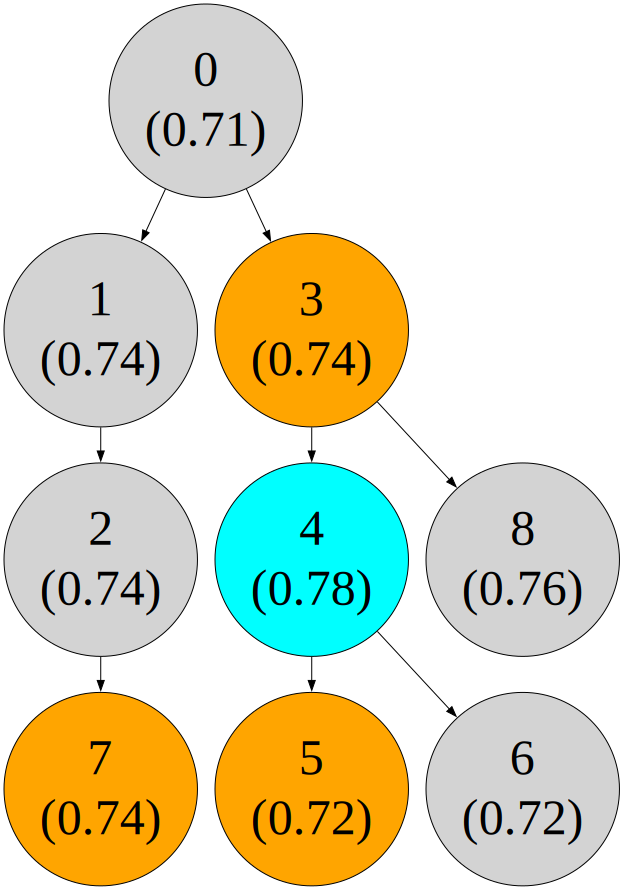

In [33]:
from IPython.display import SVG

SVG('../optimization_results/graphviz_titanic.svg')

In [34]:
result.best_candidate

{'instructions': 'Classify a facility support email by urgency, sentiment, and categories.\n\nDo this:\n1) Read the full content, including the Subject line.\n2) Assign urgency (one of: high, medium, low):\n- High: Explicit urgent/immediate/escalation language (e.g., “urgent,” “immediate,” “ASAP,” “escalate”) OR a current safety/security hazard OR a critical service disruption now (e.g., power outage, gas smell/leak, active flooding/burst pipe, sparking/electrical fire risk, elevator entrapment, active break-in/security breach). Prior failed attempts + request for immediate action also indicate high.\n- Medium: Time-bound request (days/this week/soon) or an active issue that affects comfort/operations but is not an immediate hazard (e.g., ongoing leak contained but present, HVAC performance decline, minor plumbing issues). Phrases like “as soon as possible,” “sooner rather than later,” or “at your earliest convenience” with an active issue typically ⇒ medium.\n- Low: Routine inquiry or

* Helper to create new models based on a candidate config

In [35]:
from gepadantic import apply_candidate_to_signature_model, apply_candidate_to_tool_model

EmailInput = apply_candidate_to_signature_model(EmailInput, result.best_candidate)

FacilitySupportAnalyzer = apply_candidate_to_tool_model(FacilitySupportAnalyzer, result.best_candidate)

In [36]:
EmailInput.model_json_schema()

{'description': 'Schema: EmailInput has one field, input (str), which is the raw email text—Subject plus body—to classify into urgency, sentiment, and categories using the rules above.',
 'properties': {'input': {'description': 'Raw email content (Subject + body) as received. Consider the Subject for urgency cues. Ignore placeholders like [Sender]/[Receiver] and signatures/disclaimers; focus on the described issues, tone, and explicit requests. Extract signals of urgency, tone markers, and map content to the allowed categories only.',
   'title': 'Input',
   'type': 'string'}},
 'required': ['input'],
 'title': 'EmailInput',
 'type': 'object'}

In [37]:
FacilitySupportAnalyzer.model_json_schema()

{'description': 'Return a single JSON classification for the facility support email with keys: urgency (high/medium/low), sentiment (positive/neutral/negative), and categories (array of allowed labels). Do not include any extra keys or text.',
 'properties': {'urgency': {'description': 'One of: high, medium, low.\n- High: Explicit urgent/immediate/escalation language OR current safety/security hazard OR critical service disruption (e.g., power outage, gas leak/smell, active flooding/burst pipe, sparking/electrical hazard, elevator entrapment, active security breach). Prior failed attempts + request for immediate action also indicate high.\n- Medium: Time-bound request (days/this week/soon) or an active but non‑hazard issue affecting comfort/operations (e.g., minor/contained leak, HVAC performance decline, routine follow‑up needed). Phrases like “as soon as possible,” “sooner rather than later,” or “earliest convenience” when an active issue exists ⇒ medium.\n- Low: Routine inquiry or f

* Or, we could just update the code

In [38]:
class EmailInput(BaseModel):
    """\
Schema: EmailInput has one field, input (str), which is the raw email text—Subject plus body—to classify into urgency, sentiment, \
and categories using the rules above."""
    
    input: str = Field(description="""\
Raw email content (Subject + body) as received. Consider the Subject for urgency cues. Ignore placeholders like [Sender]/[Receiver] and \
signatures/disclaimers; focus on the described issues, tone, and explicit requests. Extract signals of urgency, tone markers, \
and map content to the allowed categories only.
""")

In [39]:
class FacilitySupportAnalyzer(BaseModel):
    """\
Return a single JSON classification for the facility support email with keys: urgency (high/medium/low), \
sentiment (positive/neutral/negative), and categories (array of allowed labels). Do not include any extra keys or text."""
    
    urgency: Literal['low', 'medium', 'high'] = Field(description="""\
One of: high, medium, low.
- High: Explicit urgent/immediate/escalation language OR current safety/security hazard \
OR critical service disruption (e.g., power outage, gas leak/smell, active flooding/burst pipe, sparking/electrical hazard, \
elevator entrapment, active security breach). Prior failed attempts + request for immediate action also indicate high.
- Medium: Time-bound request (days/this week/soon) or an active but non‑hazard issue affecting comfort/operations (e.g., minor/contained \
leak, HVAC performance decline, routine follow‑up needed). Phrases like “as soon as possible,” “sooner rather than later,” or “earliest convenience” \
when an active issue exists ⇒ medium.
- Low: Routine inquiry or flexible scheduling with no active issue or disruption.""")
    
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="""\
One of: positive, neutral, negative. Judge by tone, not issue presence.
- Positive: Appreciative/praising/polite warmth/confident language (e.g., thanks, appreciate, fantastic).
- Neutral: Factual/matter‑of‑fact or politely reporting an issue without clear dissatisfaction.
- Negative: Expressed dissatisfaction, frustration, disappointment, complaints about slow/poor service, or threats to escalate.""")
    
    categories: list[Literal[
        "emergency_repair_services", 
        "routine_maintenance_requests", 
        "quality_and_safety_concerns", 
        "specialized_cleaning_services", 
        "general_inquiries", 
        "sustainability_and_environmental_practices", 
        "training_and_support_requests", 
        "cleaning_services_scheduling", 
        "customer_feedback_and_complaints", 
        "facility_management_issues"]] = Field(description="""\
Array of strings. Choose any that apply from this controlled list only:
- quality_and_safety_concerns: Safety, hygiene/sanitation, cleanliness standards, compliance risk, or service quality/QA concerns (missed checks, protocol \
lapses, oversight impacting quality/safety).
- routine_maintenance_requests: Recurring/non‑acute maintenance (HVAC comfort/performance, minor leaks/plumbing, routine inspection, maintenance follow‑ups). \
If tied to missed checks/standards, also add quality_and_safety_concerns.
- customer_feedback_and_complaints: Dissatisfaction, oversight/service complaints, slow responses, escalation requests—even if politely phrased.
- specialized_cleaning_services: Deep/specialized cleaning (carpets, windows, floor care/waxing, high‑dusting) or explicit inquiries about cleaning services/practices.
- cleaning_services_scheduling: Scheduling or rescheduling a cleaning service.
- facility_management_issues: Coordination/operations/policy topics (space utilization, access control/badges, security measures/staffing, vendor governance). \
Not for specific equipment repair or a technician’s missed maintenance.
- emergency_repair_services: Immediate repair dispatch for critical failure/hazard (burst pipe/active flooding, power outage, gas leak/smell, \
sparking/electrical hazard, elevator entrapment).
- general_inquiries: Exploratory/informational questions about services/capabilities with no specific incident/work order.
- training_and_support_requests: Requests for training, SOPs, manuals, or support programs for in‑house teams.
- sustainability_and_environmental_practices: Sustainability, eco‑friendly/green cleaning, energy efficiency inquiries.""")